# Spectrogram: View the frequency content of a signal as a function of time

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd
import seaborn as sns 
import aifc
pd.options.mode.chained_assignment = None 

# Graphing helper 
def setup_graph(title='', x_label='', y_label='', fig_size=None):
    fig = plt.figure()
    if fig_size != None:
        fig.set_size_inches(fig_size[0], fig_size[1])
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.grid()

### time-domain signal
Recall from 01_introSound the example of the call of a right whale:

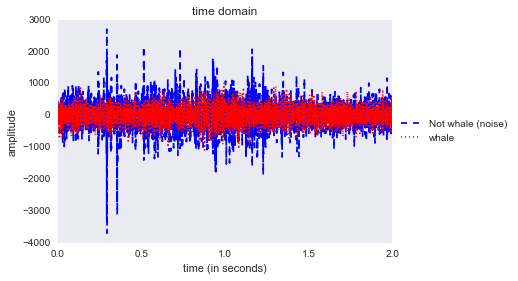

In [29]:
import pandas as pd
import seaborn as sns 
import aifc
pd.options.mode.chained_assignment = None 

#  data
trainData = pd.read_csv('data/train.csv')
# indices in Data that contain a whale call:
iWhaleCall   = [i for i, x in enumerate(trainData.label) if x == 1]
iNoWhaleCall = [i for i, x in enumerate(trainData.label) if x == 0]

clips = list(trainData.clip_name)

# data file names for example data
posFN =  'data/train/train'+str(iWhaleCall[1])+'.aiff'
negFN =  'data/train/train'+str(iNoWhaleCall[256])+'.aiff'

# open data files and sort
posSig = aifc.open(posFN, 'r')
negSig = aifc.open(negFN, 'r')


posStrSig = posSig.readframes(posSig.getnframes())
pos_y = np.fromstring(posStrSig,np.short).byteswap()

negStrSig = negSig.readframes(negSig.getnframes())
neg_y = np.fromstring(negStrSig,np.short).byteswap()

# frame rate
fs = posSig.getframerate()

# number of frames
N = posSig.getnframes()

# values
ts = 1.0/fs
t = np.arange(0,2,ts)


setup_graph(x_label='time (in seconds)', y_label='amplitude', title='time domain')
plt.plot(t, neg_y,'b--', label = 'Not whale (noise)')
plt.plot(t, pos_y,'r:', label = 'whale')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# frequency domian representation

Note that the FFT of these signal does not help make them distinguishable. 

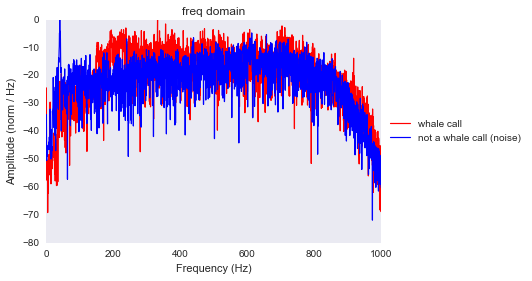

In [31]:
def nextpow2(x):
    ''' 
    calculate the next power of 2 of x
    '''
    return (x-1).bit_length()

#-----------------------------------------------------
# fft of positive signal---------------
pos_Y = np.fft.fft(pos_y, 2**nextpow2(len(pos_y))) # fft of y 
pos_Y = np.abs(pos_Y)*2/len(pos_Y)  # square the abs value of Y
pos_Y = (pos_Y/max(pos_Y))          # normalize to max val
# fft of negative signal---------------
neg_Y = np.fft.fft(neg_y, 2**nextpow2(len(neg_y))) # fft of y 
neg_Y = np.abs(neg_Y)*2/len(neg_Y)  # square the abs value of Y
neg_Y = (neg_Y/max(neg_Y))          # normalize to max val
#-----------------------------------------------------
freq  = np.linspace(0,fs,len(pos_Y)) # freq vec for non-zero pad signal
#-----------------------------------------------------
# plot on log scale --------------------
plt.figure
setup_graph(x_label='Frequency (Hz)', y_label='Amplitude (norm / Hz)', title='freq domain')
plt.plot(freq, 20*np.log10(pos_Y), 'r-',linewidth=1.2, label = 'whale call')
plt.plot(freq, 20*np.log10(neg_Y), 'b-',linewidth=1.2, label = 'not a whale call (noise)')
plt.xlim([0,fs/2])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Spectrogram

Now, if we look at the frequency content as a function of time in a spectrogram, we see the concave upsweep chirp associated with a whale call that last about 0.5 seconds and spans a frequency sweep of about 100-400 Hz. 

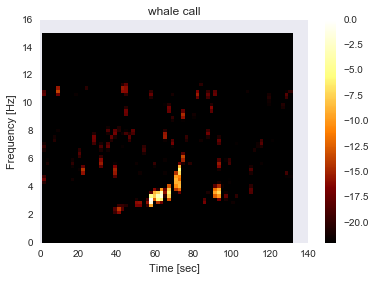

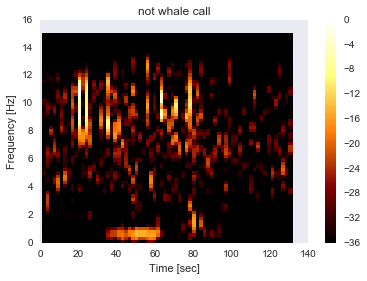

In [64]:
from scipy import signal
pos_y = signal.detrend(pos_y)
neg_y = signal.detrend(neg_y)
# whale call -------------------------
f, t, Sxx_pos1 = signal.spectrogram(pos_y, fs, nfft = 128, window = 'hamm',
                                   nperseg = 64, 
                                   detrend = 'constant', scaling = 'density')
Sxx_pos = 20*np.log10(Sxx_pos1/Sxx_pos1.max())
#Sxx_pos[Sxx_pos < -20] = -20

# not whale call -------------------------
f, t, Sxx_neg1 = signal.spectrogram(neg_y, fs, nfft = 128, window = 'hamm',  
                                   nperseg = 64,  
                                   detrend = 'constant', scaling = 'density')
Sxx_neg = 20*np.log10(Sxx_neg1/Sxx_neg1.max())
#Sxx_neg[Sxx_neg < -20] = -20

figsize=(8, 15)
plt.pcolormesh(t, f, Sxx_pos, cmap = 'afmhot',vmin=-22, vmax=0)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('whale call')
plt.colorbar()
plt.show()

figsize=(8, 15)
plt.pcolormesh(t, f, Sxx_neg, cmap = 'afmhot',vmin=-36, vmax=0)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('not whale call')
plt.colorbar()
plt.show()


Now we have some clues about the signal. We can identify the lenght of the chirp and frequency sweep. To further distinguish this signal from a noise signal, we could further window and filter the signal to clean it up further and isolate the frequencies we are interested in. Next, we could try identifying spectral peaks and comparing those found in unknown signals to those of known signals.   